<a href="https://colab.research.google.com/github/GEJ1/web-scraping-python/blob/main/Selenium_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Web scraping avanzado con Selenium**

Selenium es
* ### Selenium nos va a poder recorrer internet con un navegador sin interfaz gráfica, permitiéndonos hacer click, scroll, etc.

* ### Usar Selenium dentro de Google Colab no es lo más común pero a fines didácticos resulta útil. No estoy seguro de que tan escalable sea.

* Docs: https://selenium-python.readthedocs.io/

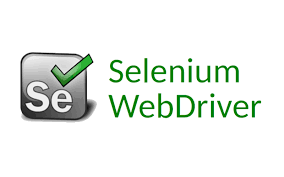

## Tenemos que instalarlo y configurarlo en Colab (en local es más fácil)

In [ ]:
%%shell
# Fuente: https://github.com/googlecolab/colabtools/issues/3347
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/116.0.5845.96/linux64/chromedriver-linux64.zip
unzip -o /tmp/chromedriver-linux64.zip -d /tmp/
chmod +x /tmp/chromedriver-linux64/chromedriver
mv /tmp/chromedriver-linux64/chromedriver /usr/local/bin/chromedriver

In [2]:
!pip install selenium -q

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service

In [4]:
options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument('--disable-dev-shm-usage')
options.add_argument("--no-sandbox")

# instanciamos el driver
wd = webdriver.Chrome(options=options)

# Tiempo  de espera ( si encuentra antes, no espera)
wd.implicitly_wait(20)

# Hacemos el pedido a la URL
url = "https://www.wikipedia.com"
# Pedido HTTP
wd.get(url)
h1 = wd.find_element(By.CSS_SELECTOR, "h1")
print(f'h1 extraido de wikipedia: \n\n{h1.text}')

h1 extraido de wikipedia: 

Wikipedia
The Free Encyclopedia


In [5]:
search_input = wd.find_element(By.ID,'searchInput')

# Envio el texto que quiero que ponga en el formulario
search_input.send_keys('Natural language processing')
wd.save_screenshot("1.png")

search_button = wd.find_element(By.XPATH,'//*[@id="search-form"]/fieldset/button')
search_button.click()
wd.save_screenshot("2.png")

True

In [ ]:
# Imprimo el título de la página a la que se accedió
heading = wd.find_element(By.ID,"firstHeading")
body_content = wd.find_element(By.ID, "bodyContent")
print(f'Heading: \n{heading.text}')
print(f'Content: \n{body_content.text}')

## **Caso de uso Nº 1: Scroll infinito**

Existen páginas que no muestran todo el contenido a menos que vayamos hasta abajo (*scroll*). Esta acción dispara un evento de javascript que renderiza más HTML y por lo tanto vemos contenido nuevo.

Podemos emular la acción de mediante Selenium.

In [9]:
# Configuramos el web driver
driver = webdriver.Chrome(options=options)

# Hacemos el pedido a la URL
url = "https://infinite-scroll.com/demo/full-page/"
driver.get(url)

# Busco todos los h2 (notar la sutileza del metodo elements en plural)
h2_list = driver.find_elements(By.CSS_SELECTOR, "h2")
for h2 in h2_list:
  print(h2.text)

1a - Infinite Scroll full page demo
1b - RGB Schemes logo in Computer Arts


In [10]:
# Tomo un screenshot
driver.save_screenshot(f'infinite_page.screenshot.png')

# Hago lo mismo que antes pero iterando 5 veces y pidiendole que scrollee hasta el final cada vez y saque un screenshot
for i in range(5):
  print(f'Iteracion numero {i}\n\n')
  # el metodo execute_script me permite ejecutar codigo de javascript, en este caso para ir al final de la pagina
  driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
  driver.save_screenshot(f'infinite_page_{i}.screenshot.png')
  h2_list = driver.find_elements(By.CSS_SELECTOR, "h2")
  for h2 in h2_list:
    print(h2.text)
  print('\n\n')

Iteracion numero 0


1a - Infinite Scroll full page demo
1b - RGB Schemes logo in Computer Arts
2a - RGB Schemes logo
2b - Masonry gets horizontalOrder
2c - Every vector 2016



Iteracion numero 1


1a - Infinite Scroll full page demo
1b - RGB Schemes logo in Computer Arts
2a - RGB Schemes logo
2b - Masonry gets horizontalOrder
2c - Every vector 2016
3a - Logo Pizza delivered
3b - Some CodePens
3c - 365daysofmusic.com
3d - Holograms



Iteracion numero 2


1a - Infinite Scroll full page demo
1b - RGB Schemes logo in Computer Arts
2a - RGB Schemes logo
2b - Masonry gets horizontalOrder
2c - Every vector 2016
3a - Logo Pizza delivered
3b - Some CodePens
3c - 365daysofmusic.com
3d - Holograms
4a - Huebee: 1-click color picker
4b - Word is Flickity is good



Iteracion numero 3


1a - Infinite Scroll full page demo
1b - RGB Schemes logo in Computer Arts
2a - RGB Schemes logo
2b - Masonry gets horizontalOrder
2c - Every vector 2016
3a - Logo Pizza delivered
3b - Some CodePens
3c - 365daysof

## **Caso de uso Nº 2: Páginas que usan JavaScript para mostrar el contenido de manera asíncrona**

* Hay páginas que cuando hacemos un request a su URL no nos devuelve lo que esperamos. Sino bastante código de JavaScript (entre etiquetas `<script>`)

* En esos casos hay que esperar un tiempo y/o interactuar con la pagina.

Ejemplo: http://www.parrocchiemap.it/parrocchiemap/ricerca_pm.jsp?diocesi=Milano&idzonapastoraler=296


In [11]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.ui import Select

idzonapastorale_value = []
idzonapastorale_text = []

driver = webdriver.Chrome(options=options)

url = "http://www.parrocchiemap.it/parrocchiemap/ricerca_pm.jsp?diocesi=Milano&idzonapastoraler=296"

# Hacemos el pedido a la URL
driver.get(url)

# Ejecuto codigo de javacript para ir al final de la pagina
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

# # Espero a que cargue la pagina
WebDriverWait(driver, timeout=5)


# El metodo Select nos permite acceder a las opciones en un menu desplegable (drop-down)
select = Select(driver.find_element(By.ID, 'idzonapastorale'))
for item in select.options:
    print(item.get_attribute('innerText'), item.get_attribute('value'))
    idzonapastorale_value.append(item.get_attribute('value'))
    idzonapastorale_text.append(item.get_attribute('innerText'))

- -1
Zona Past. VII - Sesto S. Giovanni 296
Zona Pastorale I - Milano 292
Zona Pastorale II - Varese 295
Zona Pastorale III - Lecco 297
Zona Pastorale IV - Rho 294
Zona Pastorale V - Monza 293
Zona Pastorale VI - Melegnano 298


In [12]:
pagesource_list = []

diocesi = 'Milano'
for zona in idzonapastorale_value:
  print(f'Mirando la zona: {zona}' )
  # Configuramos el web driver
  driver = webdriver.Chrome(options=options)
  idzonapastorale = zona
  url = f"http://www.parrocchiemap.it/parrocchiemap/ricerca_pm.jsp?diocesi={diocesi}&idzonapastoraler={idzonapastorale}"

  # Hacemos el pedido a la URL
  driver.get(url)

  driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

  # # Espero a que cargue la pagina a la vieja usanza
  # time.sleep(10)
  WebDriverWait(driver, timeout=5)

  # Cambio el driver para que este en el iframe
  driver.switch_to.frame(driver.find_element(By.TAG_NAME, "iframe"))

  # Una manera de quedarse con el HTML
  html = driver.execute_script("return document.getElementsByTagName('html')[0].innerHTML")

  # Otra manera usando el atributo del web driver
  pageSource = driver.page_source

  pagesource_list.append(pageSource)

  driver.save_screenshot(f'screenshot_{zona}.png')

Mirando la zona: -1
Mirando la zona: 296
Mirando la zona: 292
Mirando la zona: 295
Mirando la zona: 297
Mirando la zona: 294
Mirando la zona: 293
Mirando la zona: 298


In [13]:
# Proceso los mails
import re

def procesar_mails(pagesource_list):
  mails_total = []

  for zona in pagesource_list:
    mails = []
    pos = []
    # obteniendo los mails
    match = re.findall(r'(mailto:\S+@\S+)', zona)

    for num, i in enumerate(match):
      pos.append(num)
      lista = i.split('+')
      mail = ''.join(lista[0][7:].replace("'", "")+lista[1].replace("'", "")+lista[2].replace("'", "")).split(',')[0].split(';')[0]
      mails.append(mail)

    mails_total.append(mails)

  return mails_total

mails_total = procesar_mails(pagesource_list)

In [14]:
# Armo un Pandas Dataframe en base al diccionario
import pandas as pd

diccionario_mails = dict()
df_list = []
for num, zona in enumerate(idzonapastorale_text[1:]):
   diccionario_mails[f'df{num+1}']= pd.DataFrame(mails_total[num+1], columns=[f'{zona}'])
   df_list.append(diccionario_mails[f'df{num+1}'])

df_final = pd.concat(df_list, axis=1)


# Pasamos el dataframe a formato csv
df_final.to_csv('output.csv') # Si pasan como argumento un string con el nombre del archivo lo guarda. Ej: 'datos.csv'

In [15]:
driver.close()

### Las posibilidades son enormes!

#### Básicamente podemos recorrer cualquier pagina web clickeando, scrolleando , completando formularios o lo que sea usando Python y con posibilidad de automatizarlo completamente.

Algunos ejemplos más:

```python
# Para ir al final de un documento: https://stackoverflow.com/questions/20986631/how-can-i-scroll-a-web-page-using-selenium-webdriver-in-python
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
```
Algunas formas de seleccionar elementos <br>
`<input type="text" name="passwd" id="passwd-id" />`

```python
# Diferentes formas de seleccionar un elemento
find_element(By.ID, "passwd-id")
find_element(By.NAME, "passwd")
find_element(By.XPATH, "//input[@id='passwd-id']")
find_element(By.CSS_SELECTOR, "input#passwd-id")

# Y hay más!!
find_element(By.LINK_TEXT, "link text")
find_element(By.PARTIAL_LINK_TEXT, "partial link text")
find_element(By.TAG_NAME, "tag name")
find_element(By.CLASS_NAME, "class name")
```

# **Ideas? Sugerencias? Algo para charlar?**

<img src='https://chandigarhx.com/wp-content/uploads/2017/04/coffee-ideas.jpg'>